# Deep Planet Task
##### Joshua Placidi

#### Task: Given a cropped image and a background image find the location of the cropped image in the background image

### Imports and set up

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models

from random import randint
from PIL import Image
import json, os, math, time
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Define model

Using the VGG19 model architecture to extract features from images. The last (classification) layer of the model is removed so image features can be extracted.

In [2]:
vgg19_model = models.vgg19(pretrained=True) # Load pretrained VGG19 model
vgg19_model.classifier = nn.Sequential(*list(vgg19_model.classifier.children())[:-1]) # Remove last linear layer of VGG19
vgg19_model.eval()
vgg19_model.to(device) # Move to GPU
print(vgg19_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Helper Functions

In [3]:
# Function to calculate random x,y coordinates to crop image at
def image_crop(image_size, crop_size):
    image_width, image_height = image_size
    crop_x = randint(0,image_width-crop_size)
    crop_y = randint(0,image_height-crop_size)
    return crop_x, crop_y

# Function to calculate the features of two images and return the distance between the feature tensors
def feature_distance(features1, features2):
    if features1.shape == features2.shape:
        # Return distance between feature tensors
        return torch.dist(features1, features2).item()
    else:
        raise ValueError('Feature tensors are different sizes: ' + str(feature1.shape) + ' and ' + str(feature2.shape))

# Pass image through VGG model and return calculated features
def get_image_features(image):
    image = image.unsqueeze(0).to(device)
    if(image.shape[1] == 3):
        features = vgg19_model(image)
        return features
    else:
        return None

# Plots cropped and bg image next to each other
def plot_crop_and_bg(crop, bg):
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(crop)
    ax[0].set_title('Cropped Image (no added noise)')
    ax[0].axis('off')
    ax[1].imshow(bg)
    ax[1].set_title('Background Image (with random noise added)')
    fig.set_size_inches(10, 5)
    ax[1].axis('off')
    plt.show()

# Add guassian noise to an image
def add_noise(image_in, amount):
    image = np.array(image_in)
    if len(image.shape) == 3:
        row,col,ch = image.shape
        mean = 0.5
        var = amount
        sigma = var**1
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return Image.fromarray(np.uint8(noisy)).convert('RGB')
    else:
        return image_in

### Define Dataset

Using arial image dataset DOTA: https://captain-whu.github.io/DOTA/dataset.html
        
#### Define dataset to return a noisy background image, a random non-noisy cropped image from the background, and the true coordinates (top left (x,y)) of the cropped image in the background

In [4]:
class ImageDataset(Dataset):
    def __init__(self, json_dir, crop_size, noise_amount):
        
        # Loop through json file and load each image path into self.image_paths
        with open(json_dir) as file:
            json_data = json.load(file)
        self.image_paths = []
        for image in json_data['images']:
            self.image_paths.append(image['path'])
        
        # Transformations
        self.resize = transforms.Resize((600,600))
        self.crop_size = crop_size
        self.to_tensor = transforms.ToTensor()
        self.noise_amount = noise_amount
        self.centre_crop = transforms.CenterCrop(500)
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Open background image and resize it to (500,500)
        background_image = Image.open(self.image_paths[idx])
        background_image = self.resize(background_image)
        background_image = self.centre_crop(background_image)
        
        # Get random valid crop_x, crop_y coordinates in background image
        crop_x, crop_y = image_crop(background_image.size, self.crop_size)
        
        # Create new cropped image
        cropped_image = background_image.crop((crop_x, crop_y, crop_x + self.crop_size, crop_y + self.crop_size))
        
        # Introduce random noise into just the background image
        noisy_background_image = add_noise(background_image, self.noise_amount)
        
        # Convert background and cropped image to tensors
        background_tensor = self.to_tensor(noisy_background_image)
        crop_tensor = self.to_tensor(cropped_image)
        
        return crop_tensor, background_tensor, crop_x, crop_y

### Load Dataset

Load dataset with desired crop_size

In [5]:
# crop_size = width and height of cropped images
crop_size = 150

data = ImageDataset('sat_data.json', crop_size, noise_amount = 10)

### Define Run Function

Loop through Dataset loading background and cropped image pairs. For each background image loop through its coordinates with kernel of size crop_size and stride size =stride_size. Calculate the image features for each kernel stride and compare it to the cropped image features. Assign the kernel stride with the most similarity to the cropped image as the best selection, similarity is defined as the distance between the image tensors (smaller = more similiar)

In [6]:
def run(stride_size=50, image_count=len(data), print_images=False):
    # Initilise variables
    counter = 0
    total_error = 0
    start_time = time.time()
    
    # Loop through each sample in the dataset
    for crop_tensor, background_tensor, crop_x, crop_y in tqdm(data):
        
        # Print results if each image_count has been reached
        if(counter >= image_count): 
            break
        
        # Convert tensors to np arrays
        np_crop = np.transpose(crop_tensor, (1, 2, 0))
        np_bg = np.transpose(background_tensor, (1, 2, 0))
        
        if(print_images):
            # Print background and cropped pair next to each other
            plot_crop_and_bg(np_crop, np_bg)
        
        # Initialise variable
        bg_image = transforms.ToPILImage()(background_tensor)
        _, bg_width, bg_height = background_tensor.shape
        minimum = 1000
        best_stride = (0,0) 
        x = 0
        cropped_image_features = get_image_features(crop_tensor)
        
        # Stride through image calculating features for each kernel and comparing them to the cropped image
        while (x < bg_width-crop_size):
            y=0
            while (y < (bg_height - crop_size)):
                # Calculate the current kernel image and its features
                kernel_region = bg_image.crop((x, y, x+crop_size, y+crop_size))
                kernel_features = get_image_features(transforms.ToTensor()(kernel_region))
                
                if kernel_features != None and cropped_image_features != None:
                    # Calculate the distance between
                    distance = feature_distance(cropped_image_features, kernel_features)

                    # If this kernel returns a new minimum distance between features then set it as the new minimum and best stride
                    if(distance < minimum):
                        minimum = distance
                        best_stride = (x,y)
                y += stride_size
            x += stride_size


        best_x, best_y = best_stride
        
        if(print_images):
            # Print the background image with the predicted and ground truth cropped regions overlayed
            predicted_crop = bg_image.crop((best_x, best_y, best_x + crop_size, best_y + crop_size))
            
            fig,ax = plt.subplots(1)
            ax.imshow(np_bg)
            
            real = patches.Rectangle((crop_x, crop_y),crop_size,crop_size,linewidth=2,edgecolor='limegreen',facecolor='none')
            predicted = patches.Rectangle((best_x, best_y),crop_size,crop_size,linewidth=2,edgecolor='darkorange',facecolor='none')
            
            ax.add_patch(real)
            ax.add_patch(predicted)
            fig.set_size_inches(20, 10)
            plt.title('Predicted Crop (Orange), Real Crop (Green)')
            plt.axis('off')
            plt.show()
        
        # Calculate distance between top left of predicted and ground truth regions as the error
        total_error += math.sqrt(((best_x - crop_x) ** 2) + ((best_y - crop_y) ** 2))
        
        counter += 1
    end_time = time.time()
    print('Stride_size: ' + str(stride_size) + '  ---------------------')
    print('Mean error per image: ' + str(round(total_error/image_count,5)))
    print('Mean time per image: ' + str(round((end_time-start_time)/image_count,5)) + ' seconds' + '\n')

### Visualise Samples

Visualise samples from the dataset with predicions and ground truths

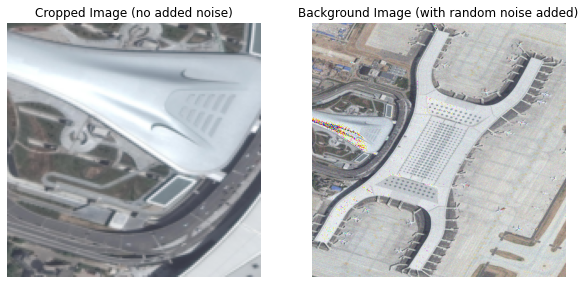

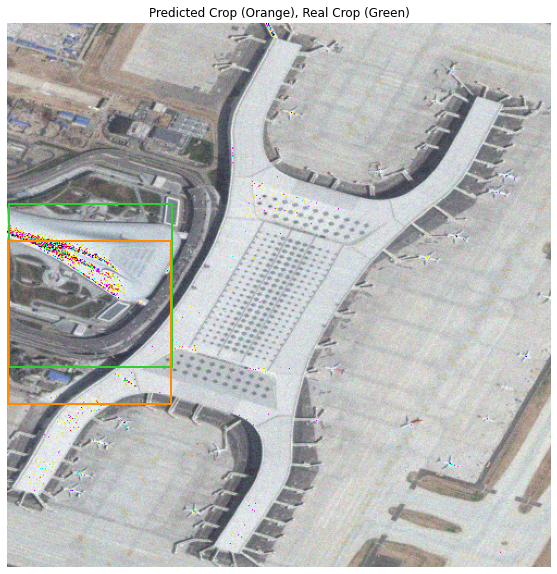

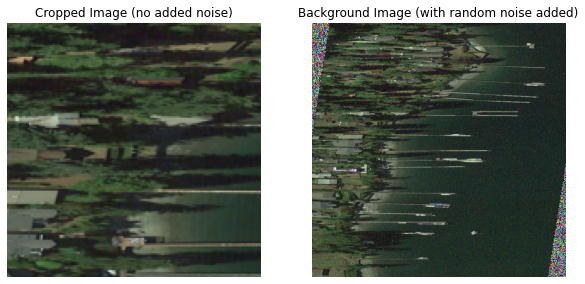

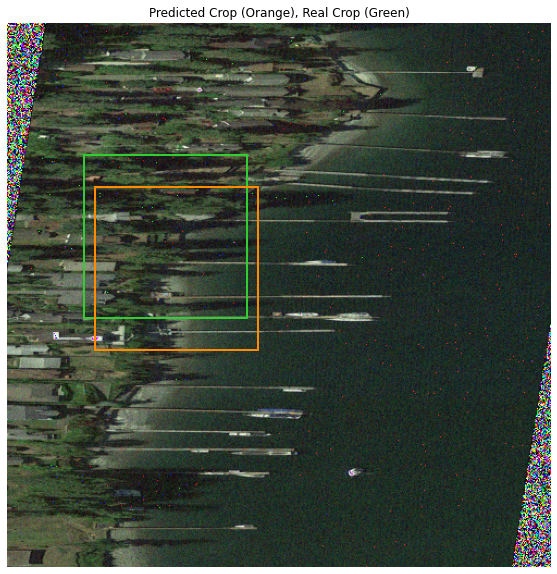

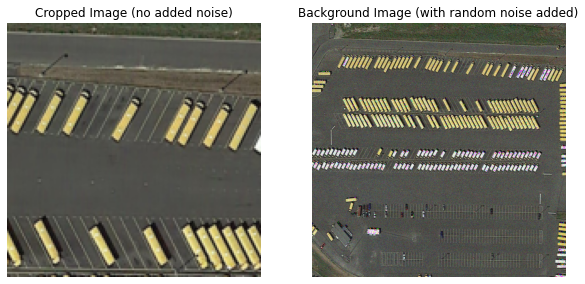

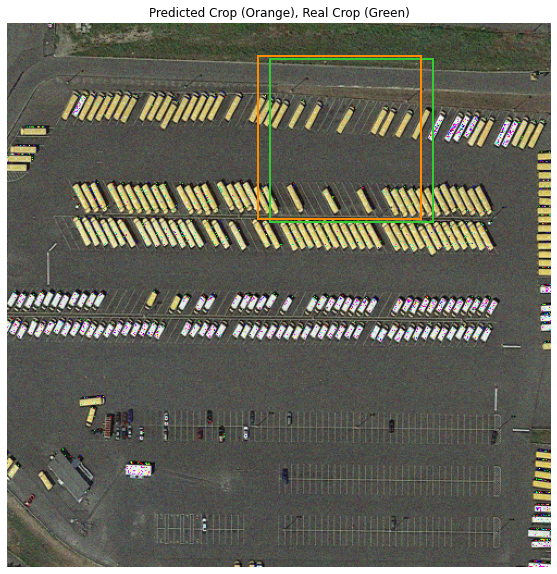

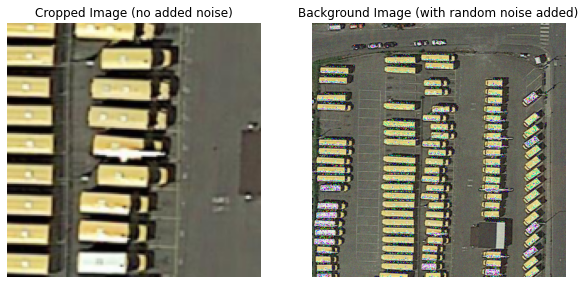

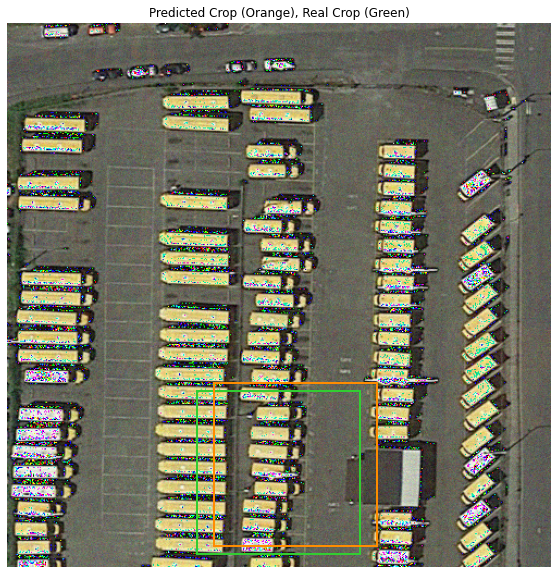

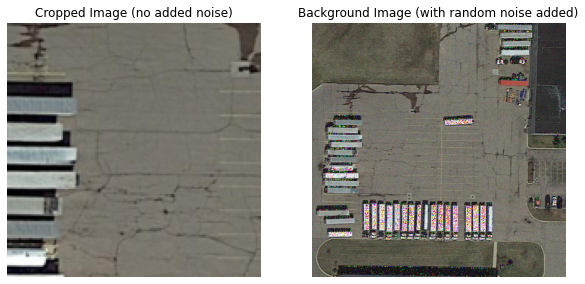

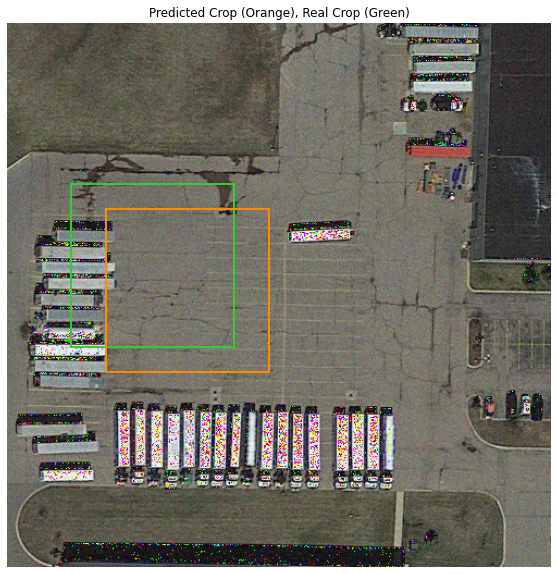


Stride_size: 10  ---------------------
Mean error per image: 26.63349
Mean time per image: 7.3798 seconds



In [7]:
run(stride_size=10, image_count=5, print_images=True)

### Accuracy vs Runtime

Run tests with different stride_size to compare the average error and average time per image for each test.

In [8]:
run(stride_size=25) # 400 strides for 500x500 image
run(stride_size=50) # 100 strides
run(stride_size=100) # 25 strides


Stride_size: 25  ---------------------
Mean error per image: 93.66325
Mean time per image: 1.29551 seconds




Stride_size: 50  ---------------------
Mean error per image: 107.17465
Mean time per image: 0.49284 seconds




Stride_size: 100  ---------------------
Mean error per image: 122.47706
Mean time per image: 0.30146 seconds



As expected we can see that with smaller stride_size we get less error but longer average image run time, this shows the trade off between accuracy and run time

### Improvements

To improve this algorithm I would implement the following:
- A more sophisticated region iteration system rather then just looping through the image. Perhaps using a similar system to how RCNNs propose regions
- A bounding box regression system to regress region proposals closer to the true value
- Create a custom model trained on real data that can learn to ignore noise and focus of other image features